# Phoneme Classification 音素分类
![任务](asset/task.png)

## 课题目标

音位是一种语言中能够区别词之间意义的最小语音单位。本课题的目标为根据训练数据集训练出一个可靠的模型，能够将音频特征正确归类到41个音位类中。）


## 课题数据集

训练数据：3429 个带标签的预处理音频特征（共2116794帧）

测试数据： 857 个未经标签预处理的音频特征（共 527364 帧）

数据集共有41个类，每一个类代表了一个音位（phoneme）

## 数据准备

class LibriDataset类是一个自定义的数据集类，继承自Dataset类。Dataset类是PyTorch提供的一个抽象类，用于表示数据集对象。

LibriDataset类的实现包括以下几个方法：

1. __init__(self, X, y=None): 这是类的初始化方法，接受两个参数X和y。X表示数据，y表示标签。在初始化过程中，将数据X赋值给self.data属性。如果标签y不为空，则将y转换为torch.LongTensor类型并赋值给self.label属性，否则将self.label设置为None。

2. __getitem__(self, idx): 这个方法用于获取数据集中指定索引位置idx的数据和对应的标签。如果self.label不为空，则返回数据和对应的标签。否则，只返回数据。

3. __len__(self): 这个方法用于获取数据集的长度，即数据的个数。

LibriDataset类的作用是创建一个数据集对象，该对象包含数据和标签，并提供了获取数据和标签的方法。通过继承Dataset类，LibriDataset类可以方便地与PyTorch中的其他数据处理工具和模型进行集成和使用。

## 数据预处理

preprocess.py包含了用于数据预处理的函数的定义及实现。
首先，函数same_seeds(seed)用于设置随机数种子，以确保代码的可重复性。load_feat(path)函数用于加载特征数据。shift(x, n)函数用于将特征数据向左或向右平移n个位置。concat_feat(x, concat_n)函数用于将特征数据进行拼接。preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8, random_seed=1213)函数用于对数据进行预处理。

根据给定的划分（训练集、验证集或测试集）和参数进行了以下处理：

1. 加载特征数据：使用load_feat函数加载特征数据。
2. 平移操作：使用shift函数对特征数据进行左右平移操作，根据参数n的正负值确定平移方向和距离。
3. 特征拼接：使用concat_feat函数对特征数据进行拼接，根据参数concat_n确定拼接的窗口大小。
4. 数据集划分：根据划分参数和训练集比例，将数据集划分为训练集和验证集。
5. 数据存储：将处理后的特征数据和对应的标签存储到张量X和y中。
6. 数据截取：根据实际有效数据的长度，截取张量X和y的有效部分。
7. 返回结果：根据划分参数，返回处理后的特征数据和标签数据（如果是训练集或验证集）或者只返回特征数据（如果是测试集）。

通过这些数据预处理步骤，可以得到适合模型训练和测试的数据集对象，其中特征数据已经进行了平移和拼接处理，标签数据已经与特征数据对应，并且数据集已经按照划分进行了划分和截取。

具体参数：
1. preprocess_data：
   - split：数据集的划分，可以是'train'（训练集）、'val'（验证集）或'test'（测试集）。
   - feat_dir：特征数据的文件夹路径。
   - phone_path：标签数据的文件夹路径。
   - concat_nframes：拼接的窗口大小，即每个特征向量与前后多少个特征向量进行拼接。
   - train_ratio：训练集所占比例，默认为0.8。
   - random_seed：随机数种子，默认为1213。

2. shift：
   - x：输入的特征数据张量。
   - n：平移的距离，负值表示向左平移，正值表示向右平移。

3. concat_feat：
   - x：输入的特征数据张量。
   - concat_n：拼接的窗口大小，即每个特征向量与前后多少个特征向量进行拼接。

4. same_seeds：
   - seed：随机数种子。

这些函数的参数用于控制数据的预处理过程。根据具体的需求和数据特点，可以调整这些参数来适应不同的数据集和模型。

由于数据集选取的是音频，preprocess_data遵循MFCC（Mel-frequency cepstral coefficients），一种在频域上对声音信号进行建模和表示的方法。

MFCC的提取过程包括以下步骤：
1. 预处理：对原始音频信号进行预处理，如去除静音、降噪等。
2. 分帧：将音频信号分成短时帧，通常每帧持续时间为20-40毫秒。
3. 加窗：对每帧应用窗函数（如汉明窗）以减少频谱泄漏。
4. 傅里叶变换：将每帧的时域信号转换为频域表示，通常使用快速傅里叶变换（FFT）。
5. 梅尔滤波器组：将频谱通过一组梅尔滤波器进行滤波，这些滤波器的中心频率在梅尔刻度上均匀分布。
6. 对数运算：对每个滤波器的能量取对数，以对数刻度表示音频信号的能量。
7. 倒谱系数提取：对每个滤波器组的对数能量进行离散余弦变换（DCT）得到倒谱系数。
8. 降维：通常只保留部分倒谱系数，以减少特征的维度。
9. 特征拼接：将连续的帧的MFCC系数进行拼接，以捕捉时间上的动态信息。

MFCC特征在语音识别、说话人识别、语音合成等领域广泛应用，它能够提取出语音信号的重要特征，具有较好的鲁棒性和表达能力。

## 多种传统机器学习分类模型的对比和分析

### 1. 逻辑斯蒂回归

逻辑回归是一种用于解决二分类问题的机器学习算法。

In [1]:
import torch

class LogisticRegression(torch.nn.Module):
    def __init__(self,input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

首先用PyTorch实现了逻辑回归模型，通过一个线性层和sigmoid函数将输入数据转换为0到1之间的概率值，用于二分类问题的预测。

逻辑斯蒂回归本身只能用于二分类问题，如果实际情况是多分类的，那么就需要对模型进行一些改动，以下是三种比较常用的将逻辑斯蒂回归用于多分类的方法：

#### 1.1 One vs One

OvO 的方法就是将多个类别中抽出来两个类别，然后将对应的样本输入到一个逻辑斯蒂回归的模型中，学到一个对这两个类别的分类器，然后重复以上的步骤，直到所有类别两两之间都存在一个分类器。

分类器的数量=C(k, 2)，k 代表类别的数量。

本次作业实现OneVsOneLRClassifier，该模型基于逻辑回归实现了一对一的多类别分类，训练过程中对41个类别进行两两组合，以构建模型。通过BCELoss和SGD优化器进行训练，在每个组合的循环中，迭代了指定次数的epoch以训练模型。预测阶段，对于每个类别组合，生成预测概率，并根据各个组合的投票结果确定最终类别标签。最后，通过get_final_predictions函数获取最终预测结果，并将结果写入CSV文件，完成了模型的预测过程。

代码文件位于ml_classification/model/LogisticRegressionClassifier/oneVsOneLRClassifier.py

测试脚本位于ml_classification/scripts/ovoLRC.py

In [2]:
class OneVsOneLRClassifier:
    def __init__(self, input_dim, output_dim=41,random_state=None,num_epoch=50,learning_rate=1e-2):
        self.input_dim = input_dim
        self.num_classes = output_dim
        self.classifiers = {}
        self.random_state = random_state
        self.num_epoch=num_epoch
        self.learning_rate=learning_rate

    def train(self, train_data, train_labels, device):
        for i, j in combinations(range(self.num_classes), 2):
            cond = torch.logical_or(train_labels == i, train_labels == j)
            train_data_ij = train_data[cond].to(device)
            train_labels_ij = train_labels[cond].to(device)  # train_label
            model = LogisticRegression(self.input_dim).to(device)
            criterion = torch.nn.BCELoss(reduction='sum')
            optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate)

            for epoch in range(self.num_epoch):
                y_pred = model(train_data_ij)
                loss = criterion(y_pred, train_labels_ij.float().view(-1, 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            self.classifiers[f'{i}_{j}'] = model
            print(f"Classifier for classes {i} and {j} trained.")


    #每个 predictions 都是针对一对类别的预测概率，而 results 列表包含了所有这些预测结果。
    def predict(self, test_data):
        results = []
        for i, j in combinations(range(self.num_classes), 2):
            classifier = self.classifiers[f'{i}_{j}']
            predictions = classifier(test_data)
            results.append(predictions)
        return results

    #确定最终类别的标签
    def get_final_predictions(self,results):
        final_predictions = []
        for i in range(len(results[0])):
            class_votes = Counter()
            for prediction in results:
                class_votes[prediction[i].argmax().item()] += 1
            final_predictions.append(class_votes.most_common(1)[0][0])

        return torch.tensor(final_predictions)

    def predict_and_write_to_file(self, test_loader, device, output_file='prediction.csv'):
        self.predictions = torch.tensor([])

        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                features = batch.to(device)
                pred = self.get_final_predictions(self.predict(features))
                self.predictions = torch.cat((self.predictions, pred), dim=0)
                print(f"Batch {i + 1} processed.")

        with open(output_file, 'w') as f:
            f.write('Id,Class\n')
            for i, y in enumerate(self.predictions):
                f.write(f'{i},{y.item()}\n')

OvO 的方法中，当需要预测的类别变得很多的时候，那么我们需要进行训练的分类器也变得很多了，这一方面提高了训练开销，但在另一方面，每一个训练器中，因为只需要输入两个类别对应的训练样本即可，这样就又减少了开销。

从预测的角度考虑，这种方式需要运行的分类器非常多，而无法降低每个分类器的预测时间复杂度，因此预测的开销较大。

基于简单的计算可以看出该任务的分类器的个数共有C(41,2)=820，分类器个数较多，导致计算最终预测结果的时间较长。

测试集共有527364个样本，batch_size=32,测试时共需要527364/32=16480个batch

<img src="asset/ovoLRC.png" alt="ovoLRC测试情况" width="500" height="400">

发现100个batch需要花费3分钟，故16480个batch需要花费大约8个多小时，计算时间消耗太大，导致没有能够得到最终的预测结果。

#### 1.2 One vs All

OvA 的方法就是从所有类别中依次选择一个类别作为1，其他所有类别作为0，来训练分类器，因此分类器的数量要比 OvO 的数量少得多。

分类器的数量就是就是类别的数量，也就是k。

虽然分类器的数量下降了，但是对于每一个分类器来说，训练时需要将所有的训练数据全部输入进去进行训练，因此每一个分类器的训练时间复杂度是高于 OvO 的。

从预测的方面来说，因为分类器的数量较少，而每个分类器的预测时间复杂度不变，因此总体的预测时间复杂度小于 OvA。

预测结果的确定，是根据每个分类器对其对应的类别1的概率进行排序，选择概率最高的那个类别作为最终的预测类别。

本次作业实现OneVsAllLRClassifier，该模型基于逻辑回归实现了一对多的多类别分类，针对每个类别训练一个与其余类别进行对比的二元分类器。通过BCELoss和SGD优化器进行训练，在每个类别循环中，对模型进行了指定次数的epoch迭代。在预测阶段，针对每个类别的分类器，生成预测概率，最后根据概率最大值确定最终的类别标签。通过predict_and_write_to_file函数将预测结果写入CSV文件，完成了整个预测过程。
代码文件位于ml_classification/model/LogisticRegressionClassifier/oneVsAllLRClassifier.py
测试脚本位于ml_classification/scripts/ovaLRC.py

In [3]:
class OneVsAllLRClassifier:
    def __init__(self, input_dim, output_dim=41, random_state=None, num_epoch=50, learning_rate=1e-2):
        self.input_dim = input_dim
        self.num_classes = output_dim
        self.classifiers = {}
        self.random_state = random_state
        self.num_epoch = num_epoch
        self.learning_rate = learning_rate

    def train(self, train_data, train_labels, device):
        for i in range(self.num_classes):
            # Train a binary classifier for class i vs. all other classes
            cond = train_labels == i
            train_data_i = train_data.to(device)
            train_labels_i = torch.tensor(cond, dtype=torch.float).to(device)

            model = LogisticRegression(self.input_dim).to(device)
            criterion = torch.nn.BCELoss(reduction='sum')
            optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate)

            for epoch in range(self.num_epoch):
                y_pred = model(train_data_i)
                loss = criterion(y_pred, train_labels_i.view(-1, 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            self.classifiers[str(i)] = model
            print(f"Classifier for class {i} trained.")

    def predict(self, test_data, device):
        results = torch.zeros(len(test_data), self.num_classes, dtype=torch.float).to(device)
        for i in range(self.num_classes):
            classifier = self.classifiers[str(i)]
            predictions = classifier(test_data)
            results[:, i] = predictions.squeeze()
        return results

    def predict_and_write_to_file(self, test_loader, device, output_file='prediction.csv'):
        self.predictions = torch.tensor([]).to(device)

        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                features = batch.to(device)
                pred = self.predict(features, device)

                self.predictions = torch.cat((self.predictions, pred), dim=0)
                print(f"Batch {i + 1} processed.")

        with open(output_file, 'w') as f:
            f.write('Id,Class\n')
            for i, y in enumerate(self.predictions):
                class_id = torch.argmax(y).item()
                f.write(f'{i},{class_id}\n')

##### 增大每个分类器的num_epoch

由于分类器个数较多，每个分类器训练较多的epoch时间花销太高，此次实验增加每个分类器的num_epoch从5到50到500，将预测结果提交到kaggle上评测结果如下图:

<img src="asset/ovaLRC.png" alt="ovaLRC测试情况" width="1000" height="400">

与下面其他方法相比可以看出逻辑回归在这个多分类任务上表现不佳（当然现有结果还可以做超参数调优等来提高），结合本次任务，可能有以下原因：
- 特征不足或特征不明显：逻辑回归的性能通常受限于特征的质量。如果特征无法充分表达类别间的差异，模型可能无法准确分类数据。
- 类别不平衡：如果数据集中某些类别样本量远远多于其他类别，模型可能会倾向于对较多样本的类别做出良好预测，而对少样本的类别表现较差。
- 非线性关系：逻辑回归是一个线性分类器，无法捕捉复杂的非线性关系。如果数据的类别之间存在非线性关系，逻辑回归可能无法很好地拟合这种复杂关系。

#### 1.3 One-vs-All（OvA）和 One-vs-One（OvO）的对比总结

##### One-vs-All (OvA)：

###### 策略：
对于有 N 个类别的问题，OvA 策略会训练 N 个二元分类器，每个分类器负责区分一个类别与所有其他类别的区别。

例如，在一个有三个类别（A、B、C）的问题中，OvA 将训练三个二元分类器：一个用于区分 A 类别和非 A 类别，一个用于区分 B 类别和非 B 类别，另一个用于区分 C 类别和非 C 类别。

###### 训练和预测：
- 训练：对于每个类别，使用全部数据，其中该类别标记为正类（1），其他所有类别标记为负类（0）。
- 预测：当需要对新数据进行分类时，所有分类器进行预测，选择概率最高的那个作为最终分类结果。

###### 优点：
- 训练简单，只需要 N 次训练。
- 适用于大规模数据集和大量类别的问题。

##### One-vs-One (OvO)：

###### 策略：
OvO 策略会针对每一对类别组合训练一个二元分类器。

例如，在一个有三个类别（A、B、C）的问题中，OvO 将训练三个二元分类器：一个用于区分 A 和 B，一个用于区分 A 和 C，另一个用于区分 B 和 C。

###### 训练和预测：
- 训练：对于每对类别（N * (N - 1) / 2 对），只使用属于这两个类别的数据来训练一个分类器。
- 预测：当需要对新数据进行分类时，所有分类器进行预测，根据投票或其他规则确定最终分类结果。

###### 优点：
- 训练次数相对较少，仅需要 N * (N - 1) / 2 次训练。
- 在小规模数据集上可能更有效，尤其是对于某些算法而言。

##### 总结：
OvA 适合于大规模数据和大量类别的问题，而 OvO 则适合于小规模数据集和少量类别的问题。每种策略都有其独特的优势，选择哪种取决于具体的问题和数据情况。

##### 1.4 使用 softmax 函数

通过计算各个类别的概率，比较最高概率后，确定最终的类别。

对于类别互斥的情况，建议使用softmax,而不同类别之间关联性较强时，建议使用增加多个分类器的策略。

### 2. 决策树

决策树是一种基本的分类与回归方法，它可以看作if-then规则的集合。

将决策树转换成if-then规则的过程如下：
- 由决策树的根节点到叶节点的每一条路径构建一条规则
- 路径内部结点的特征对应规则的条件
- 叶节点的类对应规则的结论

决策树算法主要有三部分组成
- 特征选择
- 决策树生成
- 决策树剪枝

1. 特征选择

   特征选择要求我们选择出目前最能将训练数据分类的特征，由此我们需要计算信息增益，**信息增益表示的是：得知特征X的信息而使得类Y的信息的不确定性减少的程度。** 也正是由于在如何决定谁是最能将训练数据分类这个问题上，我们派生出了三种计算方法，他们分别是
   - ID3算法——以信息增益为准则进行特征选择
   - C4.5算法——以信息增益比为准则进行特征选择
   - CART算法——对于分类树，采用基尼指数最小化准则
2. 决策树的生成

   决策树的生成实际上就是不断选择最能将训练数据分类的特征的过程，但是在此过程中存在着一些细节问题
   - 当信息增益很少时，如果继续进行分类则可能产生过拟合问题，因此决策树的剪枝应运而生
   - 当特征已经无可选择，剩余的数据依然不是同一类别时，应当返回数量最多的数据所属类别
  
3. 决策树的剪枝

   如果对训练集建立完整的决策树，会使得模型过于针对训练数据，拟合了大部分的噪声，即出现过度拟合的现象。为了避免这个问题，有两种解决的办法：
   - 当熵减少的数量小于某一个阈值时，就停止分支的创建。这是一种贪心算法。
   - 先创建完整的决策树，然后再尝试消除多余的节点，也就是采用减枝的方法。

由于本数据集类别多达41个，并且数据维度很大，因此若使用ID3的决策树算法——以信息增益作为特征选择准则，会存在偏向于选择取值较多的特征的问题。因此为了优化模型在具体数据集的表现效果，我们可以采用信息增益比对这一问题进行校正。即使用C4.5算法。使用C4.5的决策树的实现代码如下：

In [4]:
'''
决策树 - C4.5
'''
import numpy as np
import time
import collections as cc
from itertools import islice
import matplotlib.pyplot as plt
'''
找到当前label集的数目最大的一个类
---------
输入：
label：当前结点拥有的label集
---------
输出：
MajorClass：当前结点拥有的label集中数目最大的一个类
'''
def FindMajorClass(label):
    MajorClass = cc.Counter(label).most_common(1)[0][0]

    return MajorClass


'''
计算经验熵
-----------
输入：
label：当前结点的样本的标记
-----------
输出：
H：当前结点的数据的标记的经验熵
'''
def Entropy(label):
    
    # 所有的类
    Class = np.unique(label)
    
    # 对每个类统计出现次数
    ClassNum = cc.Counter(label)
    
    # 得到标记的总数
    Classlen = len(label)
    
    # 初始化熵
    H = 0
    
    # 遍历每一个类
    for c in Class:
        
        # 计算每个类出现的概率
        P = ClassNum[c] / Classlen
    
        # 计算经验熵
        # 这里的对数以e为底
        if P!=0:
            H += -1 * P * np.log(P)
    
    return H


# In[5]:


'''
计算条件熵
-----------
输入：
data：当前结点的样本的数据
label：当前结点的样本的标记
-----------
输出：
C_H_Arr：当前结点的样本的条件熵
'''
def Conditional_Entropy(data, label):

    # 特征的数量
    FeatureNum = len(data[0])
    
    # 得到数据集的样本数量
    dataNum = len(data)
    
    # 将数据集转置
    data = np.transpose(data)
    
    # 准备一个空列表存放每个feature对应的经验条件熵
    C_H_Arr = []
    
    # 遍历每个特征
    for f in range(FeatureNum):
        
        # 所有样本点的特征f的值
        f_data = data[f]
        
        # 特征f的可取值
        f_value = np.unique(f_data)
        
        # 初始化特征f的经验条件熵
        C_H = 0
        
        # 遍历特征f的每一个可取值
        for f_v in f_value:
            
            # 得到f_data中值为f_v的所有index
            index = np.argwhere(f_data == f_v)
            
            # 准备一个空列表存储满足值为f_v的所有标记
            f_label = []
            
            for i in index:
                
                # 得到该特征下满足值为f_v的对应的所有标记
                f_label.append(label[i[0]])
            
            # 计算f_label的经验熵
            f_H = Entropy(f_label)
            
            # 得到在该特征下，值为f_v的概率
            f_P = len(f_label) / dataNum
            
            # 计算经验条件熵
            C_H += f_P * f_H
            
        # 记录每个特征的条件熵
        C_H_Arr.append(C_H)

    return C_H_Arr


# In[6]:


'''
将特征作为变量，计算特征的熵
-----------
输入：
data：当前结点的数据集
--------
输出：
Feature_H_Arr：当前结点数据集的所有特征的熵
'''
def Feature_Entropy(data):
    
    # 转置
    data_T = np.transpose(data)
    
    # 准备一个列表存储所有特征的熵
    Feature_H_Arr = []
    
    # 遍历每个特征
    for f in data_T:
        
        # 计算特征f的熵
        f_H = Entropy(f)
        
        # 存储特征f的熵
        Feature_H_Arr.append(f_H)
    
    return Feature_H_Arr


# In[7]:


'''
计算各个特征的信息增益比
---------
输入：
data：当前结点下的数据
label：当前结点下的标记
-----------
输出：
BestFeature：最适合用来进行分类的特征
IGMax：该特征对应的最大信息熵
'''
def InforGain_Rate(data, label):

    # 计算当前结点的经验熵
    H = Entropy(label)
    
    # 计算当前结点的经验条件熵
    C_H_Arr = Conditional_Entropy(data, label)
    
    F_H_Arr = Feature_Entropy(data)
    
    # 计算信息增益
    IG = np.array([H - num for num in C_H_Arr])
    
    # 计算信息增益比
    # 这里+0.001是为了防止出现0/0的情况
    IG_R = list(IG / (np.array(F_H_Arr) + 0.001))
    
    # 得到最大的信息增益比
    IG_RMax = max(IG_R)
    
    # 得到最大信息增益对应的特征
    BestFeature = IG_R.index(IG_RMax)
    
    return BestFeature, IG_RMax


# In[8]:


'''
在得到最适合用来划分的特征后，对数据集进行划分
----------
输入：
data：目前的数据集
label：目前的标记
feature：根据哪个特征进行划分
-------------
输出：
datasets：划分后得到的多个子集
labelsets：划分后得到的多个子集的标记
'''
def SplitDataSet(data, label, feature):
    
    # 样本数
    SampleNum = len(label)
    
    # 转置data
    data_T = np.transpose(data)
    
    # 获得最佳特征的可取值
    feature_value = np.unique(data_T[feature])
    
    # 准备两个列表，用来存放分割后的子集
    datasets = []
    labelsets = []
    
    # 遍历最佳特征的每个取值
    for f in feature_value:
        
        datasets_sub = []
        labelsets_sub = []
        
        # enumerate不仅遍历元素，同时遍历元素的下标
        # 此处遍历每个样本在最佳特征的取值和下标
        for Index, num in enumerate(data_T[feature]):

            # 当data中的某个样本的该特征=f时，获得它的index
            if num == f:
                
                # 将用于划分该样本点的最佳特征从数据集中去除
                # 去除后在下一次的迭代中将不再考虑这个特征
                data_temp = data[Index]
                data_temp=data_temp.numpy().tolist()
                del data_temp[feature]
                
                # 存储划分后的子集
                # 此时得到的仅为最佳特征的一个取值下的子集
                datasets_sub.append(data_temp)
                labelsets_sub.append(label[Index])
        
        # 存储根据最佳特征的不同取值划分的子集
        datasets.append(datasets_sub)
        labelsets.append(labelsets_sub)
    
    return datasets, labelsets


# In[9]:


'''
创建决策树
----------
输入：
pre_train_data: 当前训练集数据
pre_train_label：当前训练集标记
epsilon：阈值，如果当前结点的最大信息增益小于该值，则将该结点设为叶节点
-----------
输出：
treeDict：决策树
'''
def CreateTree(pre_train_data, pre_train_label, epsilon):

    # 类别去重
    Class = np.unique(pre_train_label)
    
    # 如果对于当前的标签集合而言，类别只有一个
    # 说明这个结点是叶结点，返回这个类
    if len(Class) == 1:
        return Class[0]
    
    # 如果已经没有特征可以进行分类了，返回当前label集中数目最多的类
    if len(pre_train_data[0]) == 0:
        return FindMajorClass(pre_train_label)
    
    # 其它情况下，需要继续对结点进行分类，计算信息增益
    # 得到信息增益最大的特征，及其信息增益
    BestFeature, IG_RMax = InforGain_Rate(pre_train_data, pre_train_label)
    
    # 如果最佳特征的信息增益小于一个我们自己设定的阈值
    # 则采用当前标记中数目最多的类
    if IG_RMax < epsilon:
        return FindMajorClass(pre_train_label)
    
    # 构建树
    # 这里使用了dict格式的特点来构建树
    # 比如得到的树是{374 : {0 : 2, 1 : {562 : {0 : 4, 1 : 7}}}}
    # 代表根结点对应特征是第374个特征
    # 如果一个样本的374特征的值为0，则该样本分类为2
    # 如果它的374特征为1，则进入子树
    # 子树的结点对应的特征为第562个特征
    # 如果样本的562特征值为0，则分类为4，如果值为1，则分类为7
    treeDict = {BestFeature:{}}
    
    # 树生成后，对数据集根据最佳特征进行划分
    subdatasets, sublabelsets = SplitDataSet(pre_train_data, pre_train_label, BestFeature)
    
    # 子集的个数
    setsNum = len(sublabelsets)
    
    # 对子集进行迭代，创建子树
    for i in range(setsNum):
        
        # 这里运用的迭代思想
        # 即在一个自定义函数中调用自己
        treeDict[BestFeature][i] = CreateTree(subdatasets[i], sublabelsets[i], epsilon)        

    return treeDict


# In[10]:


'''
对单个测试点进行分类
-----------
输入：
data：测试点数据
label：测试点标记
tree：决策树
--------
输出：
Class：该样本点被分的类
'''
def Predict(data, tree):
    Class = -1
    while Class == -1:
        print("进入循环")
        # 获得当前结点的key和value
        # key代表结点中需要对哪一个特征进行判断
        # value代表结点的可取值
        (key, value), = tree.items()
        
        # 该样本在结点所需判断的特征的值
        feature_value = data[key]
        
        # 如果判断下来，其值还是字典
        # 那么就说明还在内部结点，要继续往下分
        if type(value[feature_value]).__name__ == 'dict':

            # 将该内部结点及其子树设为新的树
            tree = value[feature_value]
            
            # 删除该结点所对应的特征
            del data[key]

        # 如果判断下来是不是字典了，说明到达叶节点
        if type(value[feature_value]).__name__ != 'dict':
            # 则返回叶结点对应的分类
            Class = value[feature_value]
    
    return Class

def predict_and_write_to_file(tree, Predict, test_data, output_file='prediction.csv'):
    predictions = []

    for i, sample in enumerate(test_data):
        try:
            print("开始预测")
            
            class_id = Predict(sample, tree)
            print("预测结束")
            print(class_id)
        except:
            class_id = -1

        predictions.append(class_id)
    with open(output_file, 'w') as f:
        f.write('Id,Class\n')
        for i, class_id in enumerate(predictions):
            f.write(f'{i},{class_id}\n')

运行结果提交后得分如下：
![决策树结果](asset/tree.png)

### 3. 支持向量机

支持向量机（Support Vector Machine，SVM）是一种常见的机器学习算法，用于二分类和多分类问题。它的目标是找到一个最优的超平面，将不同类别的样本分开。

对于二分类问题，SVM通过在特征空间中构建一个最大间隔的超平面来进行分类。该超平面使得离它最近的样本点到该超平面的距离最大化，这些样本点被称为支持向量。

SVM在构建决策边界时使用核函数来处理线性不可分的情况，这些核函数能够将样本从输入空间映射到一个更高维的特征空间。常用的核函数有线性核函数、多项式核函数、高斯核函数、Sigmoid核函数等。

In [5]:
import numpy as np
import math


class SVM:
    '''初始化参数'''

    def __init__(self, train_data, train_label, sigma, C, toler, itertime, kernel='gaussian', degree=3, coef0=0.0):

        self.train_data = train_data  # 训练集数据
        self.train_label = train_label  # 训练集标记
        self.m, self.n = np.shape(train_data)  # self.m为训练集样本容量，self.n为特征数量
        self.sigma = sigma  # 高斯核分母上的超参数
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.KernalMatrix = self.CalKernalMatrix()  # 核矩阵
        self.alpha = np.zeros(self.m)  # 初始化拉格朗日向量，长度为训练集样本容量
        self.b = 0  # 初始化参数b
        self.C = C  # 惩罚参数
        self.toler = toler  # 松弛变量
        self.itertime = itertime  # 迭代次数
        # 初始化Elist，因为alpha和b初始值为0，因此E的初始值为训练集标记的值
        self.E = [float(-1 * y) for y in self.train_label]

    '''计算核矩阵'''

    def CalKernalMatrix(self):
        if self.kernel == 'linear':
            return np.dot(self.train_data, self.train_data.T)
        elif self.kernel == 'poly':
            return (np.dot(self.train_data, self.train_data.T) + self.coef0) ** self.degree
        elif self.kernel == 'sigmoid':
            return np.tanh(np.dot(self.train_data, self.train_data.T) + self.coef0)
        elif self.kernel == 'gaussian':
            # 转换为torch张量
            X = torch.from_numpy(self.train_data)

            # 计算样本之间的欧氏距离平方
            X_squared = torch.sum(X ** 2, dim=1, keepdim=True)
            distances = X_squared - 2 * torch.matmul(X, X.t()) + X_squared.t()

            # 计算高斯核矩阵
            KernalMatrix = torch.exp(-distances / (2 * self.sigma ** 2))

            return KernalMatrix.numpy()

    '''计算g(xi)'''

    def Calgxi(self, i):

        Index = [index for index, value in enumerate(self.alpha) if value != 0]
        gxi = 0
        for index in Index:
            gxi += self.alpha[index] * self.train_label[index] * \
                   self.KernalMatrix[i][index]
        gxi = gxi + self.b

        return gxi

    '''判断是否符合KKT条件'''

    def isSatisfyKKT(self, i):

        # 获得alpha[i]的值
        alpha_i = self.alpha[i]

        # 计算yi * g(xi)
        gxi = self.Calgxi(i)
        yi = self.train_label[i]
        yi_gxi = yi * gxi

        # 判断是否符合KKT条件
        if -1 * self.toler < alpha_i < self.toler and yi_gxi >= 1:
            return True
        elif -1 * self.toler < alpha_i < self.C + self.toler and math.fabs(yi_gxi - 1) < self.toler:
            return True
        elif self.C - self.toler < alpha_i < self.C + self.toler and yi_gxi <= 1:
            return True
        return False

    '''SMO算法'''

    def SMO(self):

        # 迭代
        t = 0
        parameterchanged = 1
        while t < self.itertime and parameterchanged > 0:

            t += 1
            parameterchanged = 0
            '''选择两个alpha'''

            # 外层循环，选择第一个alpha
            for i in range(self.m):

                # 判断是否符合KKT条件，如果不满足，则选择该alpha为alpha1
                # 如果满足，则继续外层循环
                TorF = self.isSatisfyKKT(i)
                if TorF == False:
                    alpha1 = self.alpha[i]

                    # 从Earray得到alpha1对应的E1
                    E1 = self.E[i]

                    # 复制一个EMatrix，并令E1的位置为nan
                    # 这样在接下来找最大值和最小值时将不会考虑E1
                    # 这里需要使用copy，如果不用copy，改变EM_temp也会同时改变EMatrix
                    EM_temp = np.copy(self.E)
                    EM_temp[i] = np.nan

                    # 我们需要使|E1-E2|的值最大，由此选择E2
                    # 首先初始化maxE1_E2和E2及E2的下标j
                    maxE1_E2 = -1
                    E2 = np.nan
                    j = -1

                    # 内层循环
                    # 遍历EM_temp中的每一个Ei，得到使|E1-E2|最大的E和它的下标
                    for j_temp, Ej in enumerate(EM_temp):
                        if math.fabs(E1 - Ej) > maxE1_E2:
                            maxE1_E2 = math.fabs(E1 - Ej)
                            E2 = Ej
                            j = j_temp

                    # alpha2为E2对应的alpha
                    alpha2 = self.alpha[j]

                    '''求最优alpha1和alpha2'''

                    y1 = self.train_label[i]
                    y2 = self.train_label[j]

                    # 计算η
                    K11 = self.KernalMatrix[i][i]
                    K22 = self.KernalMatrix[j][j]
                    K12 = self.KernalMatrix[i][j]
                    eta = K11 + K22 - 2 * K12

                    # 计算alpha2_new
                    alpha2_new = alpha2 + y2 * (E1 - E2) / eta

                    # 计算上限H和下限L
                    if y1 != y2:
                        L = max([0, alpha2 - alpha1])
                        H = min([self.C, self.C + alpha2 - alpha1])
                    else:
                        L = max([0, alpha2 + alpha1 - self.C])
                        H = min([self.C, alpha2 + alpha1])

                    # 剪切alpha2_new
                    if alpha2_new > H:
                        alpha2_new = H
                    elif alpha2_new < L:
                        alpha2_new = L

                    # 得到alpha1_new
                    alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new)

                    '''更新b'''
                    # 计算b1_new和b2_new
                    b1_new = -1 * E1 - y1 * K11 * \
                             (alpha1_new - alpha1) - y2 * K12 * \
                             (alpha2_new - alpha2) + self.b
                    b2_new = -1 * E2 - y1 * K12 * \
                             (alpha1_new - alpha1) - y2 * K22 * \
                             (alpha2_new - alpha2) + self.b

                    # 根据alpha1和alpha2的范围确定b_new
                    if 0 < alpha1_new < self.C and 0 < alpha2_new < self.C:
                        b_new = b1_new
                    else:
                        b_new = (b1_new + b2_new) / 2

                    '''更新E'''
                    # 首先需要更新两个alpha和b
                    self.alpha[i] = alpha1_new
                    self.alpha[j] = alpha2_new
                    self.b = b_new

                    # 计算Ei_new和Ej_new
                    E1_new = self.Calgxi(i) - y1
                    E2_new = self.Calgxi(j) - y2

                    # 更新E
                    self.E[i] = E1_new
                    self.E[j] = E2_new

                    if math.fabs(alpha2_new - alpha2) >= 0.000001:
                        parameterchanged += 1

            print('itertime: %a   parameterchanged: %a' %
                  (t, parameterchanged))

        # 最后遍历一遍alpha，大于0的下标即对应支持向量
        VecIndex = [index for index, value in enumerate(
            self.alpha) if value > 0]

        # 返回支持向量的下标，之后在预测时还需要用到
        return VecIndex

    '''计算b'''

    def OptimizeB(self):

        for j, a in enumerate(self.alpha):
            if 0 < a < self.C:
                break

        yj = self.train_label[j]
        summary = 0
        for i in range(self.alpha):
            summary += self.alpha[i] * \
                       self.train_label[i] * self.KernalMatrix[i][j]

        optimiezedB = yj - summary
        self.b = optimiezedB

    '''计算单个核函数'''

    def CalSingleKernal(self, x, z):

        SingleKernal = np.exp(-1 * np.dot(x - z, x - z) /
                              (2 * np.square(self.sigma)))
        return SingleKernal

    '''单个新输入实例的预测'''

    def predict(self, x, VecIndex):

        # 决策函数计算
        # 求和项初始化
        summary = 0

        # Index中存储着不为0的alpha的下标
        for i in VecIndex:
            alphai = self.alpha[i]
            yi = self.train_label[i]
            Kernali = self.CalSingleKernal(x, self.train_data[i])

            summary += alphai * yi * Kernali

        # 最后+b
        # np.sign得到符号
        # result = np.sign(summary + self.b)
        result = summary + self.b

        return result

    '''测试模型'''

    def test(self, test_data, test_label, VecIndex):

        # 测试集实例数量
        TestNum = len(test_label)

        errorCnt = 0

        # 对每一个实例进行预测
        for i in range(TestNum):

            result = self.predict(test_data[i], VecIndex)
            if result != test_label[i]:
                errorCnt += 1

        Acc = 1 - errorCnt / TestNum

        return Acc

对于多分类问题，SVM可以使用以下两种方法进行处理：

1. 一对一（One-vs-One）方法：对于K个类别，构建K*(K-1)/2个二分类器，每个分类器将一个类别与另一个类别进行区分。在测试时，通过投票或者加权投票的方式来确定最终的分类结果。

2. 一对其余（One-vs-Rest）方法：对于K个类别，构建K个二分类器，每个分类器将一个类别与其他所有类别进行区分。在测试时，选择具有最高置信度的分类器的结果作为最终的分类结果。

这两种方法都可以用于多分类问题，但一对一方法需要构建更多的分类器，而一对其余方法只需要构建K个分类器。

SVM在多分类问题中的性能通常较好，具有较好的泛化能力。然而，对于大规模的数据集，训练时间和内存消耗可能会较高。因此，在实际应用中，可能需要结合其他技术或采用近似方法来加速和优化SVM的训练过程。

本次实验就遇到了数据集规模过大，SVM训练时间过高的难题。同时，数据集共有41个分类，难以训练完One-vs-One方法所需的820个分类器。受条件限制，对数据集进行固定的随机采样以减少时间；多分类的实现采用One-vs-Rest方法。模型效果通过验证集评估。

One-vs-Rest方法具体实现步骤如下：

1. 数据准备：首先，将原始的多分类数据集拆分为K个子数据集，每个子数据集包含一个类别作为正例样本，而其他所有类别作为负例样本。

2. 模型训练：对于每个子数据集，构建一个二分类的SVM模型。在训练过程中，将当前类别的样本标记为正例（1），而其他所有类别的样本标记为负例（-1）。

3. 模型预测：在测试阶段，对于一个新的样本，将其输入到K个SVM模型中进行预测。每个模型都会给出一个置信度或距离值，表示该样本属于正例的概率。最终，选择具有最高置信度的模型的预测结果作为最终的分类结果。

In [6]:
from collections import Counter

class MultiClassSVM:
    def __init__(self, num_classes, sigma, C, toler, itertime, kernel='gaussian', balance_method=None):
        self.num_classes = num_classes
        self.sigma = sigma
        self.C = C
        self.toler = toler
        self.itertime = itertime
        self.svm_models = []
        self.kernel = kernel
        self.balance_method = balance_method

    def balance_data(self, data, labels):
        if self.balance_method == "undersampling":
            return self.undersampling(data, labels)
        elif self.balance_method == "oversampling":
            return self.oversampling(data, labels)
        else:
            return data.numpy(), labels.numpy()

    def undersampling(self, data, labels):
        counter = Counter(labels)
        min_count = min(counter.values())
        balanced_data = []
        balanced_labels = []
        for class_label in counter.keys():
            indices = np.where(labels == class_label)[0]
            random_indices = np.random.choice(
                indices, min_count, replace=False)
            balanced_data.extend(data[random_indices].tolist())
            balanced_labels.extend(labels[random_indices].tolist())
        return np.array(balanced_data), np.array(balanced_labels)

    def oversampling(self, data, labels):
        counter = Counter(labels)
        max_count = max(counter.values())
        balanced_data = []
        balanced_labels = []
        for class_label in counter.keys():
            indices = np.where(labels == class_label)[0]
            random_indices = np.random.choice(indices, max_count, replace=True)
            balanced_data.extend(data[random_indices].tolist())
            balanced_labels.extend(labels[random_indices].tolist())
        return np.array(balanced_data), np.array(balanced_labels)

    def train(self, train_data, train_labels):
        # 进行类别平衡
        train_data, train_labels = self.balance_data(train_data, train_labels)
        for class_label in range(self.num_classes):
            # 将类别标签转换为二分类标签
            binary_labels = np.where(train_labels == class_label, 1, -1)
            # 创建SVM模型实例并训练
            svm_model = SVM(train_data, binary_labels, self.sigma,
                            self.C, self.toler, self.itertime, self.kernel)
            VecIndex = svm_model.SMO()
            self.svm_models.append((svm_model, VecIndex))

    def predict(self, test_data):
        confidences = []
        for i, (svm_model, VecIndex) in enumerate(self.svm_models):
            # 对每个类别的SVM模型进行预测
            confidence = svm_model.predict(test_data, VecIndex)
            confidences.append((i, confidence))
        confidences.sort(key=lambda x: x[1], reverse=True)
        return confidences[0][0]

    def test(self, test_data, test_labels, output_file='prediction.csv'):
        num_samples = test_data.shape[0]
        error_count = 0
        predictions = np.array([], dtype=np.int32)
        # 对每个测试样本进行预测
        for i in range(num_samples):
            pred = self.predict(test_data[i])
            if pred != test_labels[i]:
                error_count += 1
            predictions = np.concatenate(
                (predictions, np.array([pred], dtype=np.int32)), axis=0)
        accuracy = 1 - error_count / num_samples
        print(predictions)
        # 结果存入csv文件
        with open(output_file, 'w') as f:
            f.write('Id,Class\n')
            for i, y in enumerate(predictions):
                f.write('{},{}\n'.format(i, y))

        return accuracy

#### 3.1 不同核函数效果对比
```python
def CalKernalMatrix(self):
        if self.kernel == 'linear':
            return np.dot(self.train_data, self.train_data.T)
        elif self.kernel == 'poly':
            return (np.dot(self.train_data, self.train_data.T) + self.coef0) ** self.degree
        elif self.kernel == 'sigmoid':
            return np.tanh(np.dot(self.train_data, self.train_data.T) + self.coef0)
        elif self.kernel == 'gaussian':
            # 转换为torch张量
            X = torch.from_numpy(self.train_data)

            # 计算样本之间的欧氏距离平方
            X_squared = torch.sum(X ** 2, dim=1, keepdim=True)
            distances = X_squared - 2 * torch.matmul(X, X.t()) + X_squared.t()

            # 计算高斯核矩阵
            KernalMatrix = torch.exp(-distances / (2 * self.sigma ** 2))

            return KernalMatrix.numpy()
```
考虑训练成本和时间，实验在抽样800个的训练集和100个的验证集上进行，因此数据可能有所偏差。

##### 实验结果

1. 线性核函数：
   - training time:  68.54057550430298
   - Accurate:  0.0

2. 多项式核函数
   - training time:  51.35792255401611
   - Accurate:  0.020000000000000018

3. 高斯核函数
   - training time:  164.36586380004883
   - Accurate:  0.19999999999999996

4. Sigmoid核函数
   - training time:  36.597288370132446
   - Accurate:  0.0

##### 对比总结

1. 线性核函数：线性核函数是最简单的核函数之一，它将样本映射到原始的输入空间。它在处理线性可分问题时效果较好，但在处理非线性问题时效果较差。 
 
2. 多项式核函数：多项式核函数将样本映射到一个多项式特征空间。它可以处理一些简单的非线性问题，但对于复杂的非线性问题可能效果不佳。 
 
3. 高斯核函数：高斯核函数将样本映射到一个无穷维的特征空间。它在处理非线性问题时效果较好，能够捕捉到数据的复杂结构。 
 
4. Sigmoid核函数：Sigmoid核函数将样本映射到一个Sigmoid函数的输出空间。它在某些特定的问题上表现良好，但在一般情况下效果可能不如其他核函数。 

#### 3.2 类别平衡

One-vs-Rest方法的实现相对简单，它可以使用现有的二分类SVM算法来训练和预测。然而，One-vs-Rest方法在实践中可能会面临类别平衡的问题。具体来说，如果某些类别的样本数量远远大于其他类别，那么在训练过程中，模型可能会对数量较多的类别更加偏向，而对数量较少的类别的识别性能可能较差。

解决类别平衡问题的方法可以是对数据集进行重采样或采用类别加权的方式。重采样方法包括欠采样（随机删除一些数量较多的样本）和过采样（复制一些数量较少的样本）。类别加权方法可以通过设置不同类别的样本权重来平衡类别之间的影响。

相对来说，One-vs-One能更好地处理不平衡的类别分布，但由于训练成本，本次无法进行比较。这里仅简单对无处理、欠采样、过采样的情况对比。

```python
def balance_data(self, data, labels):
        if self.balance_method == "undersampling":
            return self.undersampling(data, labels)
        elif self.balance_method == "oversampling":
            return self.oversampling(data, labels)
        else:
            return data.numpy(), labels.numpy()
```
考虑训练成本和时间，实验在抽样800个的训练集和100个的验证集上进行，因此数据可能有所偏差。

##### 实验结果

1. 无处理
   - training time:  216.58953142166138
   - Accurate:  0.10999999999999999

2. 欠采样
   - training time:  159.62205243110657
   - Accurate:  0.18000000000000005

3. 过采样
   - training time:  164.36586380004883
   - Accurate:  0.19999999999999996

##### 对比总结

根据实验结果的对比，可以得出以下结论： 
 
- 无处理方法的准确率最低，说明在不进行样本平衡处理的情况下，模型对于样本不平衡的情况表现较差。 
- 欠采样和过采样方法相比无处理方法，在准确率上都有一定的提升。这表明通过减少或增加样本数量，可以改善模型对于样本不平衡问题的处理能力。 
- 欠采样和过采样方法的训练时间相对较短，说明它们在样本数量较少的情况下能够更快地进行训练。 
 
综上所述，根据实验结果，过采样方法在准确率上稍微优于欠采样方法，而且训练时间相对较短。然而，由于数据集的偏差和实验样本数量的限制，这些结果可能不具有普遍性，因此在实际应用中需要进一步评估和验证这些方法的效果。

### 不同传统机器学习模型分类结果的比较
逻辑斯蒂回归（Logistic Regression）、决策树（Decision Tree）和支持向量机（Support Vector Machine，SVM）都是常用于分类问题的机器学习算法，它们有一些相似之处，也有一些显著的差异。

1. 逻辑斯蒂回归：
- 类型： 逻辑斯蒂回归是一种线性模型，主要用于二分类问题，但可以通过扩展用于多分类问题。
- 决策边界： 逻辑斯蒂回归的决策边界是线性的，即一条直线或平面。
- 可解释性： 相对较容易解释模型的结果。

2.  决策树：
- 类型： 决策树可以用于分类和回归任务，是一种非参数化的模型。
- 决策边界： 决策树的决策边界是由一系列树节点和分支组成的，可以是复杂的非线性结构。
- 可解释性： 决策树相对容易解释，因为它们的决策过程类似于人类的决策过程。


3. 支持向量机（SVM）：

- 类型： SVM 既可以用于二分类问题，也可以通过扩展用于多分类问题。
- 决策边界： SVM 的决策边界是找到离两个类别最近的数据点之间的最大间隔的超平面，因此在高维空间中可以处理复杂的非线性关系。
- 可解释性： 相对逻辑斯蒂回归和决策树而言，SVM 的模型参数和支持向量的解释性较低。

4. 异同点：

- 相似之处：
    - 都可以用于分类问题。
    - 都可以通过调整参数来适应不同的数据和问题。
    - 在应对数据量大，类别多的超复杂问题时，效果都不如深度神经网络好
- 不同之处：
    - 决策边界形状： 逻辑斯蒂回归和SVM可以处理非线性关系，但逻辑斯蒂回归的决策边界是线性的，而SVM的决策边界可以是非线性的。决策树则可以捕捉更为复杂的非线性关系。
    - 模型复杂度： 决策树在处理复杂问题时可能会过拟合，而逻辑斯蒂回归和SVM可以通过正则化来控制模型复杂度。
    - 对异常值的敏感性： SVM对异常值相对敏感，而逻辑斯蒂回归和决策树在一定程度上对异常值具有鲁棒性。
和决策树在一定程度上对异常值具有鲁棒性。


## 多种深度学习分类模型的对比和分析

### 1. MLP

BasicBlock是一个基本的神经网络模块，包含一个简单的神经网络层序列，由一个线性层（全连接层）和一个ReLU激活函数组成。这个模块的前向传播方法（forward）接受输入 x，将输入数据通过线性层和激活函数处理后输出。

In [7]:
import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.block(x)
        return x

本次作业中首先实现一个simple的baseline-MLPClassifier，该模型采用多层感知器（MLP）的结构，通过BasicBlock组成的层级堆叠构建神经网络模型。该模型的前向传播方法（forward）接受输入 x，经过一系列由BasicBlock组成的隐藏层（可根据hidden_layers参数决定层数和hidden_dim参数决定每层神经元数），最终输出一个具有output_dim维度的张量，以完成多类别分类任务。

代码文件位于ml_classification/model/deepLearning/MLPClassfier.py

训练方法位于ml_classification/model/deepLearning/train.py（损失函数（CrossEntropyLoss）、优化器（Adam））

测试方法位于ml_classification/model/deepLearning/test.py

测试脚本位于ml_classification/scripts/MLP.py

In [8]:
import torch.nn as nn
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256):
        super(MLPClassifier, self).__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

训练函数

模型的训练过程迭代训练数据集和验证数据集，使用交叉熵作为损失函数，Adam作为优化器。在每个 epoch 中，它对模型进行训练并记录训练集和验证集的准确率和损失值。最终，它会保存在验证集上表现最好的模型参数，并提供输出记录训练的进度和最佳准确率。

In [9]:
from torch import optim
from tqdm import tqdm
import torch
import torch.nn as nn
def train(model, train_loader, val_loader, num_epoch, learning_rate,model_path, device, writer):
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    best_acc = 0.0

    for epoch in range(num_epoch):
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        for i, batch in enumerate(tqdm(train_loader)):
            # A batch consists of features data and corresponding labels.
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, train_pred = torch.max(outputs, 1)
            train_acc += (train_pred.detach() == labels.detach()).sum().item()
            train_loss += loss.item()

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)

                _, val_pred = torch.max(outputs, 1)
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += loss.item()

        # Record the accuracy and lr.
        writer.add_scalar('Acc/train', train_acc / len(train_loader.dataset), epoch)
        writer.add_scalar('Acc/valid', val_acc / len(val_loader.dataset), epoch)
        writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], epoch)

        # Print the information.
        print(
            f'[{epoch + 1:03d}/{num_epoch:03d}] Train Acc: {train_acc / len(train_loader.dataset):3.5f} Loss: {train_loss / len(train_loader):3.5f} | Val Acc: {val_acc / len(val_loader.dataset):3.5f} loss: {val_loss / len(val_loader):3.5f}')

        # If the model improves, save a checkpoint at this epoch
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f'saving model with acc {best_acc / len(val_loader.dataset):.5f}')

        print(f"{epoch + 1} lr: {optimizer.state_dict()['param_groups'][0]['lr']}")


    print(f'saving model with acc {best_acc / len(val_loader.dataset):.5f}')


# 使用示例
# train(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epoch, model_path, device, writer)

测试函数

测试函数在评估模型时，将模型设置为评估模式（eval），然后使用测试数据集进行推断，对测试数据进行迭代，获取模型输出的预测结果，并将这些结果写入指定的输出文件中，以“Id,Class”为标题，然后逐行写入测试样本的索引和模型的预测类别标签。

In [10]:
import numpy as np
import torch

def test(model, test_loader, device, output_file='result/prediction.csv'):
    model.eval()
    pred = np.array([], dtype=np.int32)

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            features = batch
            features = features.to(device)
            outputs = model(features)

            _, test_pred = torch.max(outputs, 1)
            pred = np.concatenate((pred, test_pred.cpu().numpy()), axis=0)

    with open(output_file, 'w') as f:
        f.write('Id,Class\n')
        for i, y in enumerate(pred):
            f.write('{},{}\n'.format(i, y))

#### 增加网络的隐藏层维度

固定hidden_layers=6,调整hidden_dim的值，并将预测结果提交到kaggle上评测结果如下图:

![增加网络隐藏层的对比实验](asset/dim.png)

在其他参数固定的情况下：
- concat_nframes=21
- Input dimension: 39 * concat_nframes
- Train ratio: 0.95
- Num Epoch: 15
- Learning Rate: 1e-3
- Seed: 1213
- Batch Size: 512

| hidden_layers | hidden_dim  | score  |
| ------------- | ----------- | ------ |
| 6         | 64       | 0.64314|
| -         | 128       | 0.68194|
| -       | 256          | 0.6985 |
| -     | 512          | 0.70202|
| -      | 1024         | 0.69414|

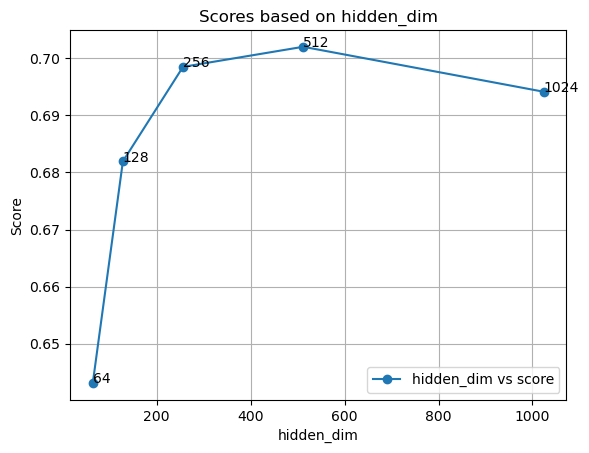

In [11]:
import matplotlib.pyplot as plt

# 假设这是您的数据
hidden_dim = [64, 128, 256, 512, 1024]
scores = [0.64314, 0.68194, 0.6985, 0.70202, 0.69414]

plt.plot(hidden_dim, scores, marker='o', label="hidden_dim vs score", linestyle='-')
plt.xlabel('hidden_dim')
plt.ylabel('Score')
plt.title('Scores based on hidden_dim')

for i, txt in enumerate(hidden_dim):
    plt.annotate(txt, (hidden_dim[i], scores[i]))

plt.legend()
plt.grid()
plt.show()

本次实验中，使用了TensorBoard记录了关于模型训练过程的数据，这有助于可视化和跟踪模型性能。

- 数据目录及设置： 设置了日志目录为 ./runs，将训练期间的损失、准确率等指标保存到该目录中。

- 启动TensorBoard： 在命令行中，通过 tensorboard --logdir=./runs 命令启动了TensorBoard，并在浏览器中输入了默认的 URL http://localhost:6006 进行访问。

- 可视化内容： 在TensorBoard界面中，我浏览了不同选项卡的内容，主要关注了 Scalars（标量）和 Graphs（图形结构）这两个标签。在 Scalars 中，我查看了损失函数和准确率随着训练步骤的变化。在 Graphs 中，我观察了模型结构和层的连接情况。

- 优点： 使用TensorBoard提供了更直观的方式来监视模型的训练过程，有助于更好地理解模型的表现。

- 终止TensorBoard服务： 在完成查看后，我使用 Ctrl + C 停止了TensorBoard服务。

TensorBoard的使用增强了对模型训练和性能评估的理解，为日后的实验提供了更便捷的监测手段。

打开TensorBoard查看训练和验证过程中增加增加网络的隐藏层维度带来的影响。

![训练](asset/dim_train.png)

![训练](asset/dim_val.png)

观察上面的结果可以发现，在神经网络中，随着隐藏层维度增加，模型的容量也增加。较大的隐藏层通常具有更多的参数，允许模型更好地拟合训练数据。因此，增加隐藏层的维度可能导致模型的表现提升，即得分提高。

然而，如果模型的容量过大，就会过度拟合训练数据，导致模型对训练数据中的噪声进行了学习，从而降低了模型对新数据的泛化能力。这可能在隐藏层维度进一步增加后表现出来，虽然模型在训练集上的得分仍在提高，但模型在验证集或测试集上的性能开始下降，即得分降低。

#### Why we  want "Deep" network,not "Fat" network?——动手试一试

##### 1.计算神经网络的参数量

先看看如何计算参数。

对于全连接层来说，其单层的参数量为 (输入维度 + 1) * 该层神经元个数。

这是因为全连接层的每个神经元都需要一个权重向量和一个偏置值来计算其输出，权重向量的长度就是输入维度，偏置值是一个标量。

若当前 network 有 hidden_layers 层 hidden layer，其中每层 hidden_layer 有 hidden_dim 维，则有：

total_params = (
    (input_dim+1) * hidden_dim +
    (hidden_dim + 1) * hidden_dim * (hidden_layers - 1) +
    (hidden_dim + 1) * output_dim
)

![全连接层](asset/mlp.png)

举例说明

In [12]:
import torch.nn as nn

input_dim = 8
hidden_dim = 16
hidden_layers = 2
output_dim = 8

# 为了简洁，舍去了 Relu()
network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # 在函数的调用中，一个 * 表示将一个序列展开为单独的位置参数，这一行代码是列表推导，最终的表现是重复生成多个 hidden layer
            *[nn.Linear(hidden_dim, hidden_dim) for _ in range(hidden_layers-1)], 
            nn.Linear(hidden_dim, output_dim)
        )
# 打印总参数量
total_params = (
    (input_dim+1) * hidden_dim +
    (hidden_dim + 1) * hidden_dim * (hidden_layers - 1) +
    (hidden_dim + 1) * output_dim
)
print(f'Total params: {total_params}')

Total params: 552


当然，实际上可以直接使用 pytorch 中的函数进行打印

In [13]:
total_params = sum(param.numel() for param in network.parameters())
print(f'Total params: {total_params}')

Total params: 552


In [14]:
for name, param in network.named_parameters():
    print(name, param.numel())

0.weight 128
0.bias 16
1.weight 256
1.bias 16
2.weight 128
2.bias 8


##### 2. 构建总参数量接近的神经网络

为了符号简便，做以下简写：
- i=input_dim
- o=output_dim
- l=hidden_layers
- d= hidden_dim

我们想对比深度神经网络和宽度神经网络，故需要在总参数量接近的情况下进行对比，那在i,o,l,d均为已知量的情况下，如果我们要在总参数量接近的情况下，将隐藏层网络层数改为: {dest_hidden_layers}，则维数应当改为多少呢？我们来设计一个函数帮助我们求解吧。

In [15]:
def get_dest_dim(input_dim, output_dim, hidden_layers, dest_hidden_layers, hidden_dim):
    '''获取目标网络隐藏层的维度（总参数量接近于原网络）'''
    # 计算一元二次方程的系数 a,b,c
    a = dest_hidden_layers - 1  # a = l_d - 1
    b = input_dim + output_dim + dest_hidden_layers  #  b = i + o + l_d
    c = - (hidden_layers - 1) * (hidden_dim ** 2) - (input_dim + output_dim + hidden_layers) * hidden_dim  # c = - (l - 1) * (d ** 2) - (i + o + l) * d
    
    # 计算分子中的平方根部分，即 b^2-4ac
    sqrt_part = (b ** 2) - 4 * a * c
    
    # 计算两个解，一个是加号，一个是减号，即(-b±√(b^2-4ac))/(2a)
    d_d_plus = (-b + sqrt_part**(0.5)) / (2 * a)
    d_d_minus = (-b - sqrt_part**(0.5)) / (2 * a)
    
    # 返回两个解的元组
    return (d_d_plus, d_d_minus)

In [16]:
concat_nframes = 21
input_dim = 39 * concat_nframes
hidden_layers = 6
hidden_dim = 512

# 设置你想要的目标网络隐藏层数量
dest_hidden_layers = 2

# 获取对应的维数
dest_hidden_dim, _ = get_dest_dim(input_dim, output_dim, hidden_layers, dest_hidden_layers, hidden_dim)
print(f"若将隐藏层网络层数改为: {dest_hidden_layers}，则维数应当改为: {round(dest_hidden_dim)}",)

若将隐藏层网络层数改为: 2，则维数应当改为: 967


对比例1：(A) 一个深窄的（隐藏层数=6，隐藏维度=512），(B) 一个浅宽的（隐藏层数=2，隐藏维度=967）。

In [17]:
concat_nframes = 21
input_dim = 39 * concat_nframes
hidden_layers = 12
hidden_dim = 1024

# 设置你想要的目标网络隐藏层数量
dest_hidden_layers = 2

# 获取对应的维数
dest_hidden_dim, _ = get_dest_dim(input_dim, output_dim, hidden_layers, dest_hidden_layers, hidden_dim)
print(f"若将隐藏层网络层数改为: {dest_hidden_layers}，则维数应当改为: {round(dest_hidden_dim)}",)

若将隐藏层网络层数改为: 2，则维数应当改为: 3130


对比例2：(A) 一个深窄的（隐藏层数=12，隐藏维度=1024），(B) 一个浅宽的（隐藏层数=2，隐藏维度=3130）。

受限于笔记本的cuda_memory，没有进行更深层的实验。

###### 对比结果和分析

将预测结果提交到kaggle上评测结果如下图:

![对比结果](asset/deep_fat.png)


| "Deep" network| score  | "Fat" network| score  |
| --------------| ------ |--------------| ------ |
|hidden_layers = 6，hidden_dim = 512| 0.70202|hidden_layers = 2，hidden_dim = 967|0.67414|
|hidden_layers = 12，hidden_dim = 1024| 0.69600|hidden_layers = 2，hidden_dim = 3130|0.68431|

分析上面的实验结果，通常来说，对于许多问题，“深度”网络通常比“宽度”网络更具优势，这是由以下一些原因所决定的：

- 表征能力： 深度网络可以更好地学习抽象和复杂的特征表示。每一层的非线性变换都有助于提取数据中的抽象特征，这有助于网络更好地理解数据。

- 泛化能力： 深度网络往往对未知数据的泛化能力更强。通过层层堆叠，网络能够更好地捕获数据中的模式，并且更少地受到局部噪声的影响。

- 计算效率： 与宽度网络相比，深度网络在参数量方面可能更有效率。更多的参数可能导致模型更容易过拟合，而深度网络能够通过分层学习更好地处理这一问题。

### 2. LSTM长短期记忆网络

LSTM（长短期记忆网络，Long Short-Term Memory）是一种常用的循环神经网络（RNN）的变体，用于处理序列数据和时间序列数据的建模和预测。

LSTM的设计目的是解决传统RNN中的梯度消失和梯度爆炸问题，使得模型能够更好地捕捉长期依赖关系。LSTM通过引入称为“门控机制”的组件来实现这一点。

LSTM中的主要组件包括：
1. 细胞状态（Cell State）：用于存储和传递信息的长期记忆。
2. 输入门（Input Gate）：决定哪些信息需要被更新到细胞状态中。
3. 遗忘门（Forget Gate）：决定哪些信息需要从细胞状态中删除。
4. 输出门（Output Gate）：决定细胞状态中的信息如何被输出。

LSTM的工作流程如下：
1. 输入门根据当前输入和前一个时间步的隐藏状态决定哪些信息需要更新到细胞状态中。
2. 遗忘门根据当前输入和前一个时间步的隐藏状态决定哪些信息需要从细胞状态中删除。
3. 根据输入门和遗忘门的结果，更新细胞状态。
4. 输出门根据当前输入和前一个时间步的隐藏状态决定细胞状态中的哪些信息需要被输出。
5. 根据输出门的结果，生成当前时间步的隐藏状态。
6. 重复上述步骤，处理序列中的每个时间步。

LSTM在自然语言处理、语音识别、机器翻译等任务中取得了很好的效果。它能够捕捉长期依赖关系，有效地处理序列数据中的上下文信息。

本实验将讨论batch normalization、drop_rate和concat_nframes对模型的影响。

In [20]:
import torch.nn as nn

class BasicBlock2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicBlock2, self).__init__()

        # TODO: apply batch normalization and dropout for strong baseline.
        # Reference: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html (batch normalization)
        #       https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html (dropout)
        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(),
            # 在此处增加 nn.Dropout()
            nn.Dropout(p=0.15)
        )

    def forward(self, x):
        x = self.block(x)
        return x

In [22]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256, drop_rate=0):
        super(LSTMClassifier, self).__init__()

        # Create BiLSTM
        self.input_size = 39  # 这一项是RNN的"input_dim"，RNN需要对"单"个数据进行处理
        self.hidden_size = 512  # 这一项是RNN的"hidden_dim"
        self.num_layers = 6  # 这一项是RNN的"hidden_layers"

        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,
                           batch_first=True, dropout=drop_rate, bidirectional=True)

        # 后接全连接层
        self.fc = nn.Sequential(
            # 修改成 2 * self.hidden_size 的原因是因为LSTM()中的bidirectional设置为了True，这表示使用Bi（双向）LSTM模型，所以需要修改输入维度以匹配
            BasicBlock2(2 * self.hidden_size, hidden_dim),
            # 在函数的调用中，一个 * 表示将一个序列展开为单独的位置参数，这一行代码是列表推导，最终的表现是重复生成多个 hidden layer
            # （原来的整段代码实际上生成了 hidden_layers+1 个隐藏层，所以我修改了一下代码，让其符合定义）
            *[BasicBlock2(hidden_dim, hidden_dim) for _ in range(hidden_layers - 1)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # 通过RNN层，得到输出和最后一个隐藏状态，注意输出的shape
        # x.shape: (batch_size, seq_len, RNN_input_size)
        x, _ = self.rnn(x)  # => (batch_size, seq_len, RNN_hidden_size)

        # 取最后一个时间步的输出作为分类的输入
        x = x[:, -1]  # => (batch_size, RNN_hidden_size)

        # 通过线性层，得到最终的分类结果
        x = self.fc(x)  # => (batch_size, labels)

        return x

#### 对照组

不做任何额外处理，即不包括batch normalization，drop_rate=0，concat_nframes使用默认值21。

| 超参数            | 值         |
|-----------------|------------|
| concat_nframes  | 21         |
| train_ratio     | 0.95       |
| seed            | 1213       |
| batch_size      | 512        |
| num_epoch       | 5          |
| learning_rate   | 1e-3       |
| model_path      | './model.ckpt' |
| input_dim       | 39 * concat_nframes |
| hidden_layers   | 6          |
| hidden_dim      | 512        |
| drop_rate       | 0          |

##### 实验结果

[001/005] Train Acc: 0.70320 Loss: 1.01483 | Val Acc: 0.75115 loss: 0.84011
saving model with acc 0.75115

[002/005] Train Acc: 0.84009 Loss: 0.53085 | Val Acc: 0.76255 loss: 0.88645
saving model with acc 0.76255

[003/005] Train Acc: 0.89338 Loss: 0.34594 | Val Acc: 0.75860 loss: 0.99680

[004/005] Train Acc: 0.91790 Loss: 0.25597 | Val Acc: 0.75773 loss: 1.07212

[005/005] Train Acc: 0.93128 Loss: 0.20589 | Val Acc: 0.76187 loss: 1.14244

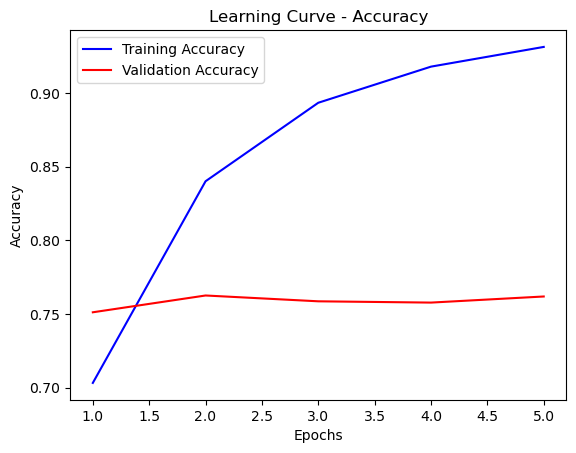

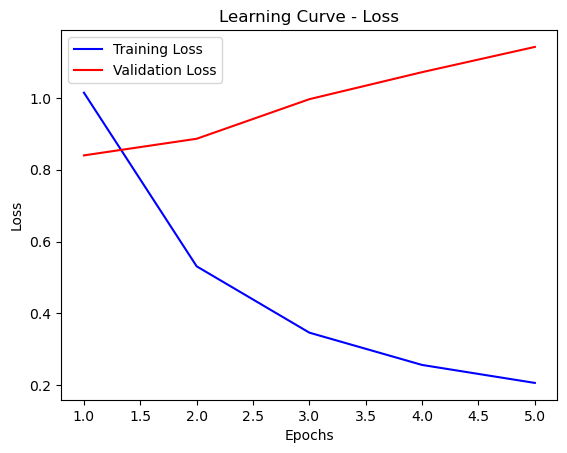

In [23]:
import matplotlib.pyplot as plt

# 定义训练和验证准确率数据
train_acc = [0.70320, 0.84009, 0.89338, 0.91790, 0.93128]
val_acc = [0.75115, 0.76255, 0.75860, 0.75773, 0.76187]

# 定义训练和验证损失数据
train_loss = [1.01483, 0.53085, 0.34594, 0.25597, 0.20589]
val_loss = [0.84011, 0.88645, 0.99680, 1.07212, 1.14244]

# 定义轮次
epochs = range(1, len(train_acc) + 1)

# 绘制训练和验证准确率曲线
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制训练和验证损失曲线
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### 分析与总结

从学习曲线图可以看出以下几点：

1. 训练准确率随着训练轮次的增加而增加，这表明模型在学习过程中逐渐提高了对训练数据的分类能力。
2. 验证准确率从第2轮次就开始上下波动，这表明模型可能已经到达了过拟合状态。
3. 训练损失在初始阶段下降较快，后续下降速度减缓；验证损失持续上升。这证明模型已经过拟合。

综上所述，模型在训练数据上表现良好，并且在验证数据上也取得了不错的性能。但是，模型直接过拟合了训练数据，因此可以考虑在训练过程中进行正则化或其他调整来改善模型的泛化能力。

#### 3.1 batch normalization

批归一化（Batch Normalization）是一种用于深度神经网络的技术，旨在加快训练速度并提高模型的性能。它通过对每个小批量的输入进行归一化处理，使得网络的内部协变量偏移问题得到缓解。

内部协变量偏移是指在训练过程中，每一层的输入分布会随着网络参数的更新而发生变化，导致网络需要不断适应这种变化。这会使得训练过程变得困难，需要更小的学习率和更长的训练时间。批归一化通过对每个小批量的输入进行归一化，将其转化为均值为0、方差为1的标准正态分布，从而减少了内部协变量偏移的影响。

批归一化的操作可以表示为：
1. 对每个小批量的输入进行归一化，使得其均值为0、方差为1。
2. 对归一化后的数据进行线性变换，通过缩放和平移操作，使得每个特征的均值和方差可学习。
3. 将线性变换后的数据作为下一层的输入。

批归一化的好处包括：
1. 加速训练过程：通过减少内部协变量偏移，网络的收敛速度更快，可以使用更大的学习率。
2. 提高模型的性能：批归一化有正则化的效果，可以减少模型的过拟合。
3. 对网络的初始值不敏感：批归一化使得网络对初始值的选择不敏感，可以更稳定地训练模型。

总之，批归一化是一种有效的技术，可以改善深度神经网络的训练过程和性能。

In [24]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256, drop_rate=0):
        super(LSTMClassifier, self).__init__()
        self.input_size = 39
        self.hidden_size = 512
        self.num_layers = 6
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers,
                           batch_first=True, dropout=drop_rate, bidirectional=True)
        
        # 添加批量归一化层
        self.bn = nn.BatchNorm1d(21)  # 对LSTM的输出进行归一化
        
        self.fc = nn.Sequential(
            BasicBlock2(2 * self.hidden_size, hidden_dim),
            *[BasicBlock2(hidden_dim, hidden_dim) for _ in range(hidden_layers - 1)],
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.bn(x) # 应用批量归一化层
        x = x[:, -1]
        x = self.fc(x)
        return x

##### 实验结果

[001/005] Train Acc: 0.70251 Loss: 1.01959 | Val Acc: 0.75107 loss: 0.85335
saving model with acc 0.75107

[002/005] Train Acc: 0.84098 Loss: 0.53289 | Val Acc: 0.76163 loss: 0.88985
saving model with acc 0.76163

[003/005] Train Acc: 0.89411 Loss: 0.34588 | Val Acc: 0.76314 loss: 0.99309
saving model with acc 0.76314

[004/005] Train Acc: 0.91871 Loss: 0.25400 | Val Acc: 0.76312 loss: 1.06621

[005/005] Train Acc: 0.93304 Loss: 0.20181 | Val Acc: 0.75983 loss: 1.13351

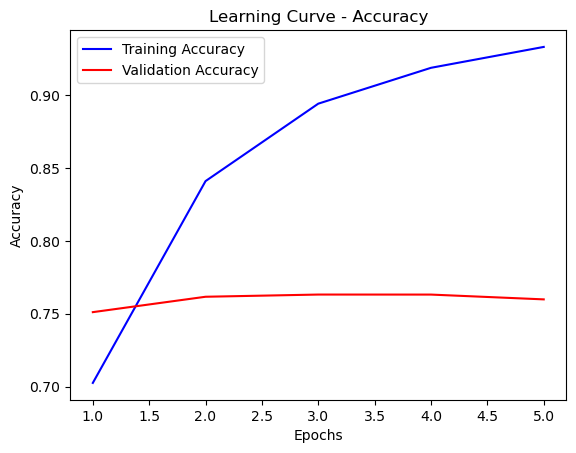

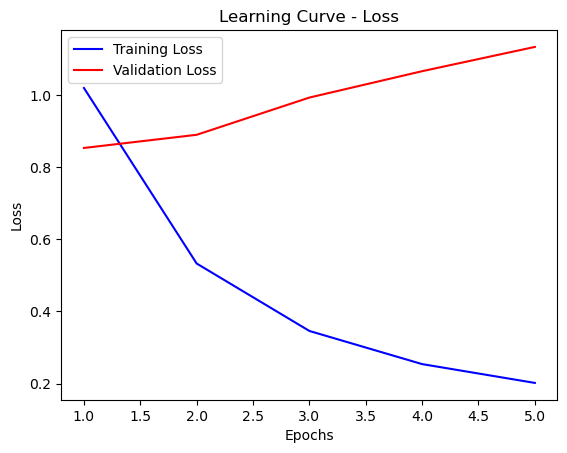

In [25]:
import matplotlib.pyplot as plt

# 定义训练和验证准确率数据
train_acc = [0.70251, 0.84098, 0.89411, 0.91871, 0.93304]
val_acc = [0.75107, 0.76163, 0.76314, 0.76312, 0.75983]

# 定义训练和验证损失数据
train_loss = [1.01959, 0.53289, 0.34588, 0.25400, 0.20181]
val_loss = [0.85335, 0.88985, 0.99309, 1.06621, 1.13351]

# 定义轮次
epochs = range(1, len(train_acc) + 1)

# 绘制训练和验证准确率曲线
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制训练和验证损失曲线
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### 分析与总结

从学习曲线图可以看出以下几点：

1. 训练准确率随着训练轮次的增加而增加，这表明模型在学习过程中逐渐提高了对训练数据的分类能力。
2. 验证准确率从第4轮次开始上下波动，这表明模型可能已经到达了过拟合状态。
3. 训练损失在初始阶段下降较快，后续下降速度减缓；验证损失持续上升。这证明模型已经过拟合。

综上所述，增加batch normalization在一定程度上减缓了过拟合的趋势，但是过拟合仍然存在。

#### 3.2 dropout

Dropout是一种用于深度神经网络的正则化技术，旨在减少过拟合并提高模型的泛化能力。它通过在训练过程中随机丢弃一部分神经元的输出，从而减少神经元之间的依赖关系。

在每个训练批次中，Dropout会以一定的概率（通常为0.5）随机地将一些神经元的输出置为0，这样被丢弃的神经元将不会对前向传播和反向传播产生任何影响。这样做的效果是，网络无法过度依赖于任何一个神经元，强制网络去学习更加鲁棒和泛化的特征。

Dropout的操作可以表示为：
1. 对于每个训练样本，在前向传播过程中以一定的概率p随机将一些神经元的输出置为0。
2. 在反向传播过程中，对于被保留的神经元，将其梯度乘以1/p，以保持梯度的期望值不变。

使用Dropout的好处包括：
1. 减少过拟合：Dropout通过随机丢弃神经元的输出，迫使网络学习更加鲁棒的特征，从而减少过拟合的风险。
2. 提高泛化能力：Dropout使得网络对于输入的微小变化更加鲁棒，提高了模型的泛化能力。
3. 防止神经元之间的共适应：Dropout减少了神经元之间的依赖关系，使得网络能够学习到更多的独立特征。

需要注意的是，在测试阶段，Dropout不会被应用，而是将所有神经元的输出乘以保留概率p，以保持期望输出值的一致性。

总之，Dropout是一种有效的正则化技术，可以减少过拟合并提高深度神经网络的泛化能力。

本次采用drop_rate = 0.3进行实验。

##### 实验结果

[001/005] Train Acc: 0.69217 Loss: 1.05679 | Val Acc: 0.74849 loss: 0.85912
saving model with acc 0.74849

[002/005] Train Acc: 0.81904 Loss: 0.60505 | Val Acc: 0.76412 loss: 0.84243
saving model with acc 0.76412

[003/005] Train Acc: 0.86588 Loss: 0.44092 | Val Acc: 0.76525 loss: 0.93335
saving model with acc 0.76525

[004/005] Train Acc: 0.88981 Loss: 0.35609 | Val Acc: 0.76609 loss: 0.97705
saving model with acc 0.76609

[005/005] Train Acc: 0.90303 Loss: 0.30705 | Val Acc: 0.76501 loss: 1.03339

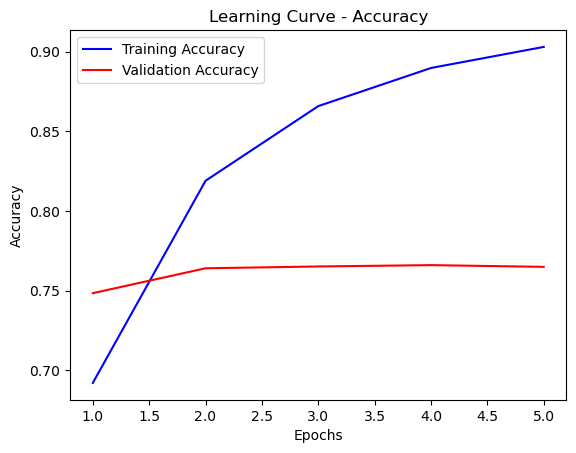

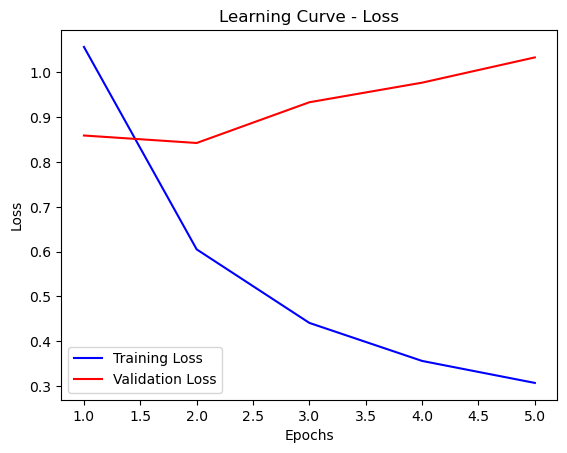

In [26]:
import matplotlib.pyplot as plt

# 定义训练和验证准确率数据
train_acc = [0.69217, 0.81904, 0.86588, 0.88981, 0.90303]
val_acc = [0.74849, 0.76412, 0.76525, 0.76609, 0.76501]

# 定义训练和验证损失数据
train_loss = [1.05679, 0.60505, 0.44092, 0.35609, 0.30705]
val_loss = [0.85912, 0.84243, 0.93335, 0.97705, 1.03339]

# 定义轮次
epochs = range(1, len(train_acc) + 1)

# 绘制训练和验证准确率曲线
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制训练和验证损失曲线
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### 分析与总结

从学习曲线图可以看出以下几点：

1. 训练准确率随着训练轮次的增加而增加，这表明模型在学习过程中逐渐提高了对训练数据的分类能力。
2. 验证准确率持续上升，在第4轮次达到顶峰，这表明模型可能在第5轮次后到达了过拟合状态。
3. 训练损失在初始阶段下降较快，后续下降速度减缓；验证损失在1、2两轮次间呈下降趋势，后又上升，证明模型已经过拟合。

综上所述，适当的drop_rate在一定程度上减缓了过拟合的趋势且效果不错，但是过拟合仍然存在。可能需要多种方法糅合，或者尝试降低模型复杂度。

#### 3.3 concat_nframes

concat_nframes用于数据预处理，作用是指定特征拼接的帧数。特征拼接是指将连续的多个帧的特征按照一定的规则进行拼接，以提供更多的上下文信息给模型。

preprocess_data中，feat表示原始的语音特征，每个特征向量的维度是39。而concat_nframes参数表示要拼接的帧数，也就是将连续的concat_nframes帧特征进行拼接。拼接后的特征向量的维度将变为39 * concat_nframes。

通过拼接连续的帧特征，模型能够获得更长的上下文信息，从而更好地捕捉到语音信号的时序特征。这对于语音识别等任务来说是很重要的，因为语音信号的含义往往依赖于其上下文环境。

总之，concat_nframes的作用是控制特征拼接的帧数，以提供更多的上下文信息给模型，从而改善语音相关任务的性能。

本次实验分别测试concat_nframes = 11 和 concat_nframes = 31 的情况。

##### 实验结果1

[001/005] Train Acc: 0.64942 Loss: 1.18356 | Val Acc: 0.69853 loss: 1.00567
saving model with acc 0.69853

[002/005] Train Acc: 0.76388 Loss: 0.78315 | Val Acc: 0.71046 loss: 1.00981
saving model with acc 0.71046

[003/005] Train Acc: 0.83301 Loss: 0.55312 | Val Acc: 0.70393 loss: 1.14280

[004/005] Train Acc: 0.88193 Loss: 0.39116 | Val Acc: 0.70222 loss: 1.27146

[005/005] Train Acc: 0.90927 Loss: 0.29831 | Val Acc: 0.69761 loss: 1.41546


##### 实验结果2

[001/005] Train Acc: 0.70738 Loss: 1.00476 | Val Acc: 0.76245 loss: 0.81532
saving model with acc 0.76245

[002/005] Train Acc: 0.85656 Loss: 0.47380 | Val Acc: 0.78140 loss: 0.83733
saving model with acc 0.78140

[003/005] Train Acc: 0.90216 Loss: 0.30780 | Val Acc: 0.78325 loss: 0.91947
saving model with acc 0.78325

[004/005] Train Acc: 0.92320 Loss: 0.22917 | Val Acc: 0.78186 loss: 0.97745

[005/005] Train Acc: 0.93408 Loss: 0.19062 | Val Acc: 0.78414 loss: 1.02542
saving model with acc 0.78414

##### 总结与分析

当concat_nframes为11时，训练损失最低为0.29831，验证损失最高为1.41546；训练准确率最高为0.90927，验证准确率最高为0.71046。可以看到，其损失相对来说最高，准确率相对来说最低。这可能是由于拼接的帧数较少，模型无法捕捉到足够长的上下文信息，导致在验证数据上的性能下降。而此时训练速度最快，几乎达到concat_nframes = 21时的三倍左右。

当concat_nframes为21时，训练损失最低为0.20589，验证损失最高为1.14244；训练准确率最高为0.93128，验证准确率最高为0.76255。这表明在拼接了更多帧的情况下，模型能够更好地捕捉到语音信号的时序特征，从而提高了性能。训练损失和验证损失也有下降的趋势，这表明模型在学习过程中逐渐减少了错误。

当concat_nframes为31时，训练损失最低为0.19062，验证损失最高为1.02542；训练准确率最高为0.93408，验证准确率最高为0.78414。训练准确率和验证准确率继续提高，并且在第三个和第五个轮次时达到了较高的准确率。这进一步证实了拼接更多帧可以提供更多上下文信息，从而改善模型的性能。训练损失和验证损失也继续下降，丰富的信息使过拟合几率下降，提高鲁棒性。但同时，其训练所花费的时间是concat_nframes = 21的两倍左右。

综合分析，可以得出以下结论：
- concat_nframes的增加可以提供更多的上下文信息，有助于改善模型的性能。
- 在本次实验中，concat_nframes为21和31的情况表现出更好的拟合情况，相较于concat_nframes为11的情况，它们在验证数据上取得了更高的准确率。
- 随着concat_nframes的增加，模型可能需要更多的训练数据和更长的训练时间来达到更好的性能。

综上所述，增加concat_nframes可以提供更多的上下文信息，从而改善模型的性能。需要根据具体任务和数据集的特点选择合适的concat_nframes值，以达到最佳的性能。